In [8]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration for plots (optional)
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [9]:
# Cell 2: Load Signal Data
# Ensure this path matches where you saved signal_data.csv from 04_signal_prediction.ipynb
signal_data_path = '/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv'
signal_df = pd.read_csv(signal_data_path, index_col='date', parse_dates=True)

print("✅ Signal data loaded.")
print(signal_df.head())
print(signal_df.tail())

✅ Signal data loaded.
              close  y_pred  y_pred_best  y_pred_xgb  y_pred_svm  \
date                                                               
2000-02-29 114.6200       0            0           0           0   
2000-03-01 130.3100       0            0           0           0   
2000-03-02 122.0000       0            0           0           0   
2000-03-03 128.0000       0            0           0           0   
2000-03-06 125.6900       0            0           0           0   

            y_pred_crossover  y_pred_rsi  
date                                      
2000-02-29                 1           0  
2000-03-01                 1           0  
2000-03-02                 1           0  
2000-03-03                 1           0  
2000-03-06                 1           0  
              close  y_pred  y_pred_best  y_pred_xgb  y_pred_svm  \
date                                                               
2025-06-18 196.5800      -1           -1          -1          -1

In [10]:
# Cell 3: Define Metrics Functions

def sharpe_ratio(returns, risk_free_rate=0.0, annual_factor=252):
    """
    Calculates the annualized Sharpe Ratio.
    Args:
        returns (pd.Series): Daily returns of the strategy or asset.
        risk_free_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        annual_factor (int): Number of trading days in a year (default 252).
    Returns:
        float: Annualized Sharpe Ratio.
    """
    if returns.std() == 0:
        return 0.0 # Avoid division by zero if there's no volatility

    # Convert annualized risk-free rate to daily
    daily_risk_free_rate = (1 + risk_free_rate)**(1/annual_factor) - 1

    excess_returns = returns - daily_risk_free_rate
    return (excess_returns.mean() * annual_factor) / \
           (excess_returns.std() * np.sqrt(annual_factor))

def max_drawdown(cumulative_returns):
    """
    Calculates the maximum drawdown of a cumulative return series.
    Args:
        cumulative_returns (pd.Series): Cumulative returns of the strategy.
    Returns:
        float: Maximum drawdown as a percentage.
    """
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def annualized_returns(returns, annual_factor=252):
    """
    Calculates the annualized returns.
    Args:
        returns (pd.Series): Daily returns of the strategy or asset.
        annual_factor (int): Number of trading days in a year (default 252).
    Returns:
        float: Annualized returns.
    """
    # Using geometric mean for compounding effect
    return (1 + returns).prod()**(annual_factor / len(returns)) - 1
    # Alternatively, for average daily return: returns.mean() * annual_factor

print("✅ Metric functions defined.")

✅ Metric functions defined.


In [11]:
# Cell 4: Calculate Strategy Returns and Cumulative Returns

# Calculate daily market returns
signal_df['market_returns'] = signal_df['close'].pct_change()

# Shift signals by one day to avoid look-ahead bias
# -1 means Short position, 0 means Hold, 1 means Long position
signal_df['position'] = signal_df['y_pred'].shift(1).fillna(0)
signal_df['position_best'] = signal_df['y_pred_best'].shift(1).fillna(0)
signal_df['position_xgb'] = signal_df['y_pred_xgb'].shift(1).fillna(0)
signal_df['position_svm'] = signal_df['y_pred_svm'].shift(1).fillna(0) # New: SVM signals
signal_df['position_crossover'] = signal_df['y_pred_crossover'].shift(1).fillna(0)
signal_df['position_rsi'] = signal_df['y_pred_rsi'].shift(1).fillna(0)


# Calculate strategy daily returns: position * market_returns
# For short positions (-1), you profit when the market drops (negative market_returns)
signal_df['strategy_returns'] = signal_df['position'] * signal_df['market_returns']
signal_df['strategy_best_returns'] = signal_df['position_best'] * signal_df['market_returns']
signal_df['strategy_xgb_returns'] = signal_df['position_xgb'] * signal_df['market_returns']
signal_df['strategy_svm_returns'] = signal_df['position_svm'] * signal_df['market_returns'] # New: SVM strategy returns
signal_df['strategy_crossover_returns'] = signal_df['position_crossover'] * signal_df['market_returns']
signal_df['strategy_rsi_returns'] = signal_df['position_rsi'] * signal_df['market_returns']


# Drop initial NaN values created by .pct_change() and .shift()
signal_df.dropna(inplace=True)

# Calculate cumulative returns (starting from 1)
signal_df['cumulative_market'] = (1 + signal_df['market_returns']).cumprod()
signal_df['cumulative_strategy'] = (1 + signal_df['strategy_returns']).cumprod()
signal_df['cumulative_strategy_best'] = (1 + signal_df['strategy_best_returns']).cumprod()
signal_df['cumulative_strategy_xgb'] = (1 + signal_df['strategy_xgb_returns']).cumprod()
signal_df['cumulative_strategy_svm'] = (1 + signal_df['strategy_svm_returns']).cumprod() # New: SVM cumulative returns
signal_df['cumulative_strategy_crossover'] = (1 + signal_df['strategy_crossover_returns']).cumprod()
signal_df['cumulative_strategy_rsi'] = (1 + signal_df['strategy_rsi_returns']).cumprod()


print("✅ Strategy returns and cumulative returns calculated.")
print(signal_df[['market_returns', 'strategy_returns', 'strategy_svm_returns']].head())

✅ Strategy returns and cumulative returns calculated.
            market_returns  strategy_returns  strategy_svm_returns
date                                                              
2000-03-01          0.1369            0.0000                0.0000
2000-03-02         -0.0638           -0.0000               -0.0000
2000-03-03          0.0492            0.0000                0.0000
2000-03-06         -0.0180           -0.0000               -0.0000
2000-03-07         -0.0224           -0.0000               -0.0000


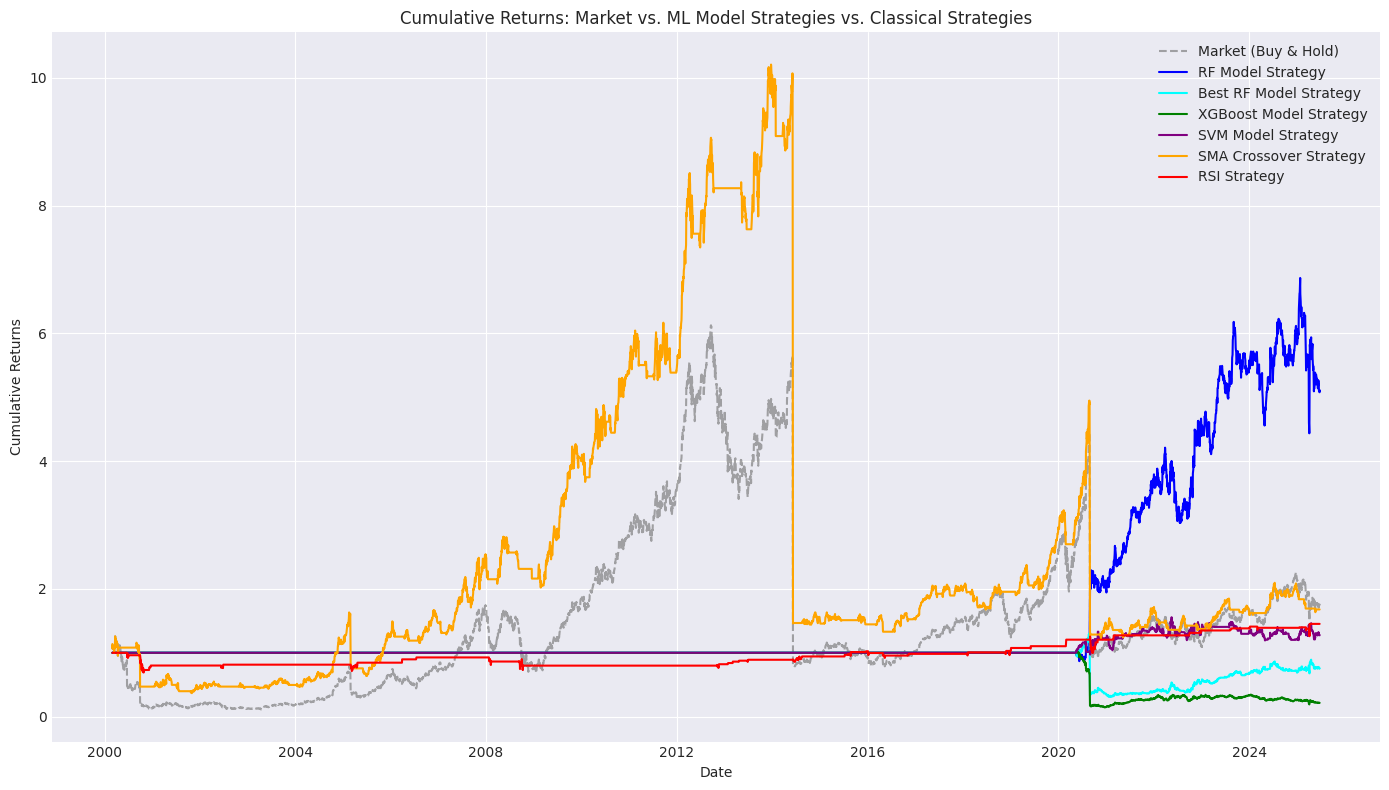

In [12]:
# Cell 5: Visualize Performance

plt.figure(figsize=(14, 8))
plt.plot(signal_df['cumulative_market'], label='Market (Buy & Hold)', color='gray', linestyle='--', alpha=0.7)
plt.plot(signal_df['cumulative_strategy'], label='RF Model Strategy', color='blue')
plt.plot(signal_df['cumulative_strategy_best'], label='Best RF Model Strategy', color='cyan')
plt.plot(signal_df['cumulative_strategy_xgb'], label='XGBoost Model Strategy', color='green')
plt.plot(signal_df['cumulative_strategy_svm'], label='SVM Model Strategy', color='purple') # New: SVM plot
plt.plot(signal_df['cumulative_strategy_crossover'], label='SMA Crossover Strategy', color='orange')
plt.plot(signal_df['cumulative_strategy_rsi'], label='RSI Strategy', color='red')

plt.title('Cumulative Returns: Market vs. ML Model Strategies vs. Classical Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Cell 6: Evaluation Metrics

print("--- Performance Metrics ---")

# Define a sample risk-free rate (e.g., 2% annually)
# You would ideally fetch this dynamically or use a relevant benchmark.
RISK_FREE_RATE = 0.02

# Annualized Returns
print("\n--- Annualized Returns ---")
print(f"Annualized Returns (RF Model):         {annualized_returns(signal_df['strategy_returns']):.2%}")
print(f"Annualized Returns (Best RF Model):    {annualized_returns(signal_df['strategy_best_returns']):.2%}")
print(f"Annualized Returns (XGBoost Model):    {annualized_returns(signal_df['strategy_xgb_returns']):.2%}")
print(f"Annualized Returns (SVM Model):        {annualized_returns(signal_df['strategy_svm_returns']):.2%}") # New
print(f"Annualized Returns (SMA Crossover):    {annualized_returns(signal_df['strategy_crossover_returns']):.2%}")
print(f"Annualized Returns (RSI Strategy):     {annualized_returns(signal_df['strategy_rsi_returns']):.2%}")
print(f"Annualized Returns (Market Buy & Hold):{annualized_returns(signal_df['market_returns']):.2%}")


# Sharpe Ratio
print("\n--- Sharpe Ratio ---")
print(f"Sharpe Ratio (RF Model):         {sharpe_ratio(signal_df['strategy_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")
print(f"Sharpe Ratio (Best RF Model):    {sharpe_ratio(signal_df['strategy_best_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")
print(f"Sharpe Ratio (XGBoost Model):    {sharpe_ratio(signal_df['strategy_xgb_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")
print(f"Sharpe Ratio (SVM Model):        {sharpe_ratio(signal_df['strategy_svm_returns'], risk_free_rate=RISK_FREE_RATE):.2f}") # New
print(f"Sharpe Ratio (SMA Crossover):    {sharpe_ratio(signal_df['strategy_crossover_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")
print(f"Sharpe Ratio (RSI Strategy):     {sharpe_ratio(signal_df['strategy_rsi_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")
print(f"Sharpe Ratio (Market Buy & Hold):{sharpe_ratio(signal_df['market_returns'], risk_free_rate=RISK_FREE_RATE):.2f}")


# Max Drawdown
print("\n--- Max Drawdown ---")
print(f"Max Drawdown (RF Model):         {max_drawdown(signal_df['cumulative_strategy']):.2%}")
print(f"Max Drawdown (Best RF Model):    {max_drawdown(signal_df['cumulative_strategy_best']):.2%}")
print(f"Max Drawdown (XGBoost Model):    {max_drawdown(signal_df['cumulative_strategy_xgb']):.2%}")
print(f"Max Drawdown (SVM Model):        {max_drawdown(signal_df['cumulative_strategy_svm']):.2%}") # New
print(f"Max Drawdown (SMA Crossover):    {max_drawdown(signal_df['cumulative_strategy_crossover']):.2%}")
print(f"Max Drawdown (RSI Strategy):     {max_drawdown(signal_df['cumulative_strategy_rsi']):.2%}")
print(f"Max Drawdown (Market Buy & Hold):{max_drawdown(signal_df['cumulative_market']):.2%}")

--- Performance Metrics ---

--- Annualized Returns ---
Annualized Returns (RF Model):         6.67%
Annualized Returns (Best RF Model):    -1.10%
Annualized Returns (XGBoost Model):    -5.88%
Annualized Returns (SVM Model):        0.96%
Annualized Returns (SMA Crossover):    2.07%
Annualized Returns (RSI Strategy):     1.49%
Annualized Returns (Market Buy & Hold):2.26%

--- Sharpe Ratio ---
Sharpe Ratio (RF Model):         0.31
Sharpe Ratio (Best RF Model):    0.00
Sharpe Ratio (XGBoost Model):    -0.24
Sharpe Ratio (SVM Model):        -0.04
Sharpe Ratio (SMA Crossover):    0.31
Sharpe Ratio (RSI Strategy):     0.00
Sharpe Ratio (Market Buy & Hold):0.34

--- Max Drawdown ---
Max Drawdown (RF Model):         -35.41%
Max Drawdown (Best RF Model):    -76.16%
Max Drawdown (XGBoost Model):    -85.86%
Max Drawdown (SVM Model):        -23.32%
Max Drawdown (SMA Crossover):    -87.98%
Max Drawdown (RSI Strategy):     -30.91%
Max Drawdown (Market Buy & Hold):-90.90%


In [14]:
# En el notebook de entrenamiento
signal_df.to_csv('/workspaces/backtesting/investment-portfolio-project/data/signal.csv', index=False)
